In [3]:
# -*- coding:utf-8 -*-
import cobra
import glob
from tqdm import tqdm
from collections import defaultdict

In [37]:
# dictionary of the in and out metabolites and their fluxes for each species in the model
# species:
#   metabolite:
#     flux
species_io_met = {}
# load the e coli model as an example to get started
models_dir = "agora-1_02/sbml"
for m_file in tqdm(glob.glob("%s/*.xml" % (models_dir))):
    model = cobra.io.read_sbml_model(m_file)
    # first get the solvers output of the model
    solution = model.optimize()
    
    # for each of the "exchange" reactions, find the incoming and outgoing fluxes 
    # using the initial stoichiometry matrix value multiplied by the solutions flux for that reaction
    # For example, a metabolite whose initial stoich value was -1 but has a flux value of -5 would be incoming.
    fluxes = {}
    for rxn in model.exchanges:
        for met in rxn.metabolites:
            stoich = rxn.metabolites[met]
            flux = stoich * solution.fluxes[rxn.id]
            fluxes[met.name] = flux
    #in_fluxes = [m for m in fluxes if fluxes[m] > 0]
    #out_fluxes = [m for m in fluxes if fluxes[m] < 0]
    #print("%d in fluxes, %d out fluxes" % (len(in_fluxes), len(out_fluxes)))
    in_out_fluxes = {m: fluxes[m] for m in fluxes if fluxes[m] != 0}
    # the model id is the ID of the strain
    species_io_met[model.id] = fluxes

100%|██████████| 818/818 [17:32<00:00,  1.29s/it]


In [41]:
out_dir = "agora-1_02"
metabolites_file = "%s/metabolites.tsv" % (out_dir)
species_metabolites_fluxes_file = "%s/species_io_fluxes.tsv" % (out_dir)

In [41]:
# first just write the metabolites along with their counts in all species to make sure we're in the right ball-park
metabolites = defaultdict(int)
for s in species_io_met:
    for m in species_io_met[s]:
        metabolites[m] += 1

print("Writing all %d metabolites to %s" % (len(metabolites.keys()), metabolites_file))
with open(metabolites_file, 'w') as out:
    out.write("".join(["%s\t%d\n" % (m, metabolites[m]) for m in sorted(metabolites)]))
    

Writing all 450 metabolites to metabolites.tsv


In [46]:
# write the parsed info to a file so it will be easier to read (takes about 15 minutes from scratch)
# I could write it to a matrix
table = []
# write the header line
table.append(["species"] + sorted(metabolites))
# now write the species and metabolites
for s in species_io_met:
    row = [s]
    for m in sorted(metabolites):
        if m in species_io_met[s]:
            row.append(str(species_io_met[s][m]))
        else:
            row.append("NA")
    table.append(row)

print("Writing the flux for each species and each metabolite to %s" % (species_metabolites_fluxes_file))
with open(species_metabolites_fluxes_file, 'w') as out:
    out.write('\n'.join(['\t'.join(row) for row in table]) + '\n')

Writing the flux for each species and each metabolite to species_io_fluxes.tsv


In [11]:
# read the species-metabolite flux values from the file
species_io_met = defaultdict(dict)
with open(species_metabolites_fluxes_file, 'r') as f:
    metabolites = f.readline().rstrip().split('\t')[1:]
    # make them all lower case
    metabolites = [m.lower() for m in metabolites]
    for line in f:
        line = line.rstrip().split('\t')
        s = line[0]
        fluxes = line[1:]
        for i in range(1,len(metabolites)):
            if fluxes[i] != "NA":
                species_io_met[s][metabolites[i]] = float(fluxes[i])
            
print("%d species, %d metabolites" % (len(species_io_met), len(metabolites)))

818 species, 450 metabolites


In [37]:
# TODO summarize the metabolites at the genus level
# first I'll just make a boxplot of all of the in and out fluxes

# do the out-fluxes first, then the in-fluxes
in_met_counts = defaultdict(int)
out_met_counts = defaultdict(int)
for s in species_io_met:
    for m in species_io_met[s]:
        # if this is an outgoing flux (i.e., into the extracellular space out of the cell):
        if species_io_met[s][m] >= 0:
            in_met_counts[m] += 1
        elif species_io_met[s][m] <= 0:
            out_met_counts[m] += 1
            
print("%d in-metabolites, %d out-metabolites" % (len(in_met_counts), len(out_met_counts)))

447 in-metabolites, 233 out-metabolites


In [43]:
#print(''.join(["%s: %d\n" % (m, out_met_counts[m]) for m in sorted(out_met_counts, key=out_met_counts.get, reverse=True)]))
out_file = "%s/out-metabolites.tsv" % (out_dir)
with open(out_file, 'w') as out:
    out.write(''.join(["%s\t%d\n" % (m, out_met_counts[m]) for m in sorted(out_met_counts, key=out_met_counts.get, reverse=True)]))

In [31]:
# these are the metabolites they were interested in from the paper:
simple_sugars = ["D-glucose", "D-fructose", "Maltose", "D-mannose", "N-acetyl-D-glucosamine", 
                 "D-glucosamine", "D-ribose", "Sucrose", "D-galactose", "Lactose", "Cellobiose", 
                 "Trehalose", "2-deoxy-D-ribose", "Aldehydo-D-xylose", "L-arabinose", "D-mannitol", 
                 "Melibiose", "Raffinose", "D-gluconate", "Salicin", "D-glucuronate", "L-rhamnose", 
                 "D-galacturonate", "D-arabinose", "L-fucose", "L-lyxose", "N-acetylneuraminate", 
                 "N-acetyl-D-galactosamine"]
simple_sugars = [m.lower() for m in simple_sugars]

# see how many of them are in the data I have
print("Checking how many of the %d simple_sugars are in the in-out fluxes table" % (len(simple_sugars)))
for m in simple_sugars:
    if m not in in_met_counts:
        print("Warning: %s not in the in-out fluxes table" % (m))

present_simple_sugars = [m for m in simple_sugars if m in in_met_counts]

simple_sugar_in_met_counts = {m:in_met_counts[m] for m in present_simple_sugars}

Checking how many of the 28 simple_sugars are in the in-out fluxes table


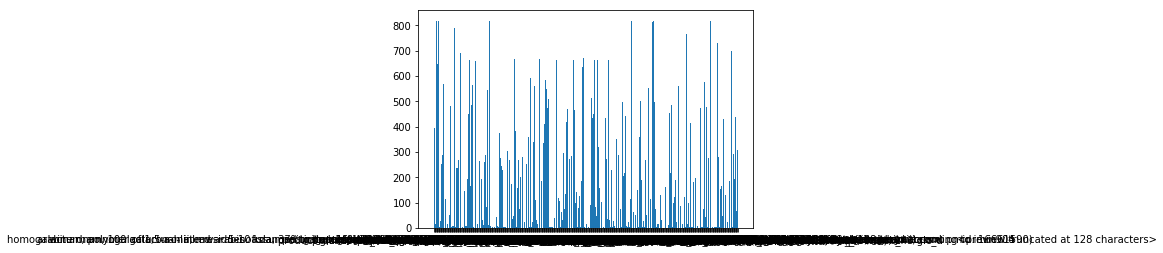

In [32]:
import matplotlib.pyplot as plt
# now plot them
#plot = plt.plot()
ind = range(len(in_met_counts))
plt.bar(ind, in_met_counts.values())
plt.xticks(ind, in_met_counts.keys())
plt.show()

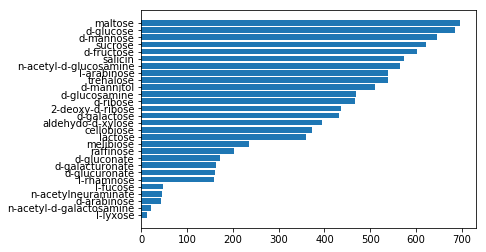

In [33]:
names = sorted(simple_sugar_in_met_counts, key=simple_sugar_in_met_counts.get)
counts = sorted(simple_sugar_in_met_counts.values())
ind = range(len(simple_sugar_in_met_counts))
plt.barh(ind, counts)
plt.yticks(ind, names)
plt.show()

In [ ]:
# now get the phyla using the species genus
microbes_file = "%s/microbes.tsv" % (out_dir)


In [5]:
model.summary()

IN FLUXES                 OUT FLUXES                OBJECTIVES
------------------------  ------------------------  ---------------
cit__91__e__...    1e+03  ac__91__e__93__    1e+03  biomass525  146
etoh__91__e_...    1e+03  co2__91__e__...    1e+03
glyleu__91__...    1e+03  for__91__e__...    1e+03
lac_D__91__e...    1e+03  h__91__e__93__     1e+03
nmn__91__e__...    1e+03  nh4__91__e__...    1e+03
thr_L__91__e...    1e+03  pi__91__e__93__    1e+03
indole__91__...  945      nac__91__e__...  998
tmao__91__e_...  913      ppa__91__e__...  977
dad_2__91__e...  662      trp_L__91__e...  937
o2__91__e__93__  421      leu_L__91__e...  936
h2__91__e__93__  405      h2o__91__e__...  913
but__91__e__...  397      tma__91__e__...  913
acald__91__e...  304      gly__91__e__...  902
glyc3p__91__...  186      fum__91__e__...  754
12ppd_S__91_...  185      xtsn__91__e_...  655
dnarep__91__...  146      acac__91__e_...  397
proteinsynth...  146      ttdca__91__e...  397
rnatrans__91...  146      ala

In [31]:
model.species()

AttributeError: 'Model' object has no attribute 'species'

In [11]:
# first get the solvers output of the model
solution = model.optimize()

In [ ]:
solution

In [24]:
fluxes = {}
for rxn in model.exchanges:
    for met in rxn.metabolites:
        stoich = rxn.metabolites[met]
        flux = stoich * solution.fluxes[rxn.id]
        fluxes[met.name] = flux
        #if flux > 0:
        #print(rxn.id, met.id, stoich, flux)

In [25]:
in_fluxes = [m for m in fluxes if fluxes[m] > 0]
out_fluxes = [m for m in fluxes if fluxes[m] < 0]
print("%d in fluxes, %d out fluxes" % (len(in_fluxes), len(out_fluxes)))

47 in fluxes, 22 out fluxes


In [28]:
print([(m, fluxes[m]) for m in in_fluxes])

[('D-Glucose 6-phosphate', 18.07033697333098), ('O2', 420.9033406718034), ('sulfate', 1.1365677367700606), ('L-valine', 59.90361365208043), ('L-lysinium(1+)', 48.54433997485769), ('RNA transcription', 145.53841995160454), ('Mn2+', 1.1365677367700606), ('(S)-propane-1,2-diol', 185.2839282030899), ('(R)-Pantothenate', 2.2731354735401275), ('butyrate', 396.93138439043094), ('Chloride', 1.1365677367700606), ('Co2+', 1.1365677367700606), ('L-threonine', 1000.0), ('Glycerol 3-phosphate', 186.08886641998697), ('calcium(2+)', 1.1365677367700606), ('Trimethylamine N-oxide', 912.6585192266139), ('ethanol', 1000.0), ('L-cysteine', 15.223144080833901), ('Citrate', 1000.0), ('Deoxyguanosine', 34.4148589045933), ('(R)-lactate', 1000.0), ('Hydrogen', 405.43663060300594), ('Indole', 944.8996781446343), ('Xanthine', 24.895427355485026), ('2-deoxyadenosine', 661.8781927122733), ('L-histidine', 13.480205071177467), ('Cytidine', 20.612169802485887), ('potassium', 1.1365677367700606), ('2-Oxoglutarate', 87